In [2]:
import argparse
import os
import yaml
import time
from inference import direct_inference, cot_inference, cot_fewshot_inference, test_1_inference, test_2_inference
from utils import get_data, evaluate_result
from prompt_template import SentimentAnalysisTemplates


In [2]:
# config

import yaml
import os

config = yaml.load(open("config.yaml", 'r'), Loader=yaml.FullLoader)
model_path = config['model_path']
output_path = config['output_path']

label_list = config['label_list']
label_dict = config['label_dict']
sentiment_type = config['sentiment_type']


In [84]:
data_fname = "Implicit_Labeled_data_for_finetune.csv"
# data_fname = "Implicit_Labeled_data_for_test.csv"
# data_fname = "incorrect_llama3.1_cot_Implicit_Labeled_data_for_test.csv"
data = get_data(data_fname)
# data = data[:20]
data

,sentence,target,label,implicit,source
0,but the staff was so horrible to us.,staff,1,0,restaurants
1,"to be completely fair, the only redeeming fact...",food,0,0,restaurants
2,"the food is uniformly exceptional, with a very...",food,0,0,restaurants
3,"the food is uniformly exceptional, with a very...",kitchen,0,0,restaurants
4,"the food is uniformly exceptional, with a very...",menu,2,1,restaurants
...,...,...,...,...,...
5817,we also use paralles so we can run virtual mac...,Windows 7 Home Premium,2,0,laptops
5818,we also use paralles so we can run virtual mac...,Windows Server Enterprise 2003,2,0,laptops
5819,we also use paralles so we can run virtual mac...,Windows Server 2008 Enterprise,2,0,laptops
5820,"how toshiba handles the repair seems to vary, ...",repair,0,0,laptops


In [85]:
data.groupby("label").count()

,sentence,target,implicit,source
label,,,,
0,3115,3115,3115,3115
1,1628,1628,1628,1628
2,1079,1079,1079,1079


In [4]:

infer_type = "test1"
model_name = "llama3.2"

# inference

print("Start inference...")
start_t = time.time()
preds = []
reasoning_texts = []
error_rows = []
for i, row in data.iterrows():
    try:
        if infer_type == "direct":
            reasoning_text, pred = direct_inference(row['sentence'], row['target'], model_name)
        elif infer_type == "cot":
            reasoning_text, pred = cot_inference(row['sentence'], row['target'], model_name)
        elif infer_type == "cot_fewshot":
            reasoning_text, pred = cot_fewshot_inference(row['sentence'], row['target'], model_name)
        elif infer_type == "test1":
            reasoning_text, pred = test_1_inference(row['sentence'], row['target'], model_name)
        elif infer_type == "test2":
            reasoning_text, pred = test_2_inference(row['sentence'], row['target'], model_name)
    except Exception as e:
        print(f"Error in row {i}: {e}")
        error_rows.append(i)
        reasoning_text, pred = [], 2
    preds.append(pred)
    reasoning_texts.append(reasoning_text)
    
    # if i % (data.shape[0] // 10) == 0:
    #     print(f"Inference in progress: {i} rows done.({i/data.shape[0]*100:.2f}%), time elapsed: {time.time()-start_t:.2f}s")

print("Inference done.")

Start inference...
Inference done.


In [20]:
reasoning_texts[14]

[{'role': 'system',
  'content': 'You are an expert of sentiment and opinion analysis.'},
 {'role': 'user',
  'content': 'Given the sentence "they did not have mayonnaise, forgot our toast, left out ingredients (ie cheese in an omelet), below hot temperatures and the bacon was so over cooked it crumbled on the plate when you touched it.",  describe any general sentiment tone about the mayonnaise? '},
 {'role': 'assistant',
  'content': 'Based on the sentence, I would say that the sentiment tone towards mayonnaise is neutral or absent. The fact that they "did not have" mayonnaise means that it was simply not available at the time of the incident, and there is no indication that this was a deliberate oversight or an error in preparation.\n\nThe focus of the criticism seems to be on other aspects of the meal, such as forgetting toast, undercooking bacon, and leaving out ingredients. Mayonnaise does not appear to be mentioned again in the sentence, suggesting that it did not play a signifi

In [21]:
data

,sentence,target,label,implicit,source
0,but the staff was so horrible to us.,staff,1,0,restaurants
1,"to be completely fair, the only redeeming fact...",food,0,0,restaurants
2,"the food is uniformly exceptional, with a very...",food,0,0,restaurants
3,"the food is uniformly exceptional, with a very...",kitchen,0,0,restaurants
4,"the food is uniformly exceptional, with a very...",menu,2,1,restaurants
5,"not only was the food outstanding, but the lit...",food,0,0,restaurants
6,"not only was the food outstanding, but the lit...",perks,0,0,restaurants
7,our agreed favorite is the orrechiete with sau...,orrechiete with sausage and chicken,0,0,restaurants
8,our agreed favorite is the orrechiete with sau...,waiters,0,0,restaurants
9,our agreed favorite is the orrechiete with sau...,meats,2,1,restaurants


In [12]:
preds

[2, 2, 0, 1, 1, 0, 2, 2, 0, 1]

In [ ]:
# cot inference

preds = []
reasoning_texts = []
# model_name = "glm-4"
model_name = "llama3.1"
error_rows = []

for i, row in data.iterrows():
    try:
        reasoning_text, pred = cot_inference(row['sentence'], row['target'], model_name)
    except Exception as e:
        print(f"Error in row {i}: {e}")
        error_rows.append(i)
        reasoning_text, pred = [], 2
    preds.append(pred)
    reasoning_texts.append(reasoning_text)
    
result = data.copy()
result['pred'] = preds
result['reasoning'] = reasoning_texts
# save the result
result.to_csv(os.path.join(output_path, f"output_{data_fname.split('.')[0]}_{model_name}.csv"), index=False)


In [6]:
from sklearn.metrics import accuracy_score, f1_score

# evaluate the result (all, and explicit only, and implicit only)

def evaluate_result(result):
    acc = accuracy_score(result['label'], result['pred'])
    f1 = f1_score(result['label'], result['pred'], average='macro')
    return acc, f1

result = data.copy()
result['pred'] = preds
result['reasoning'] = reasoning_texts

acc, f1 = evaluate_result(result)
print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}")

acc_esa, f1_esa = evaluate_result(result[result['implicit'] == 0])
print(f"Accuracy (explicit only): {acc_esa:.3f}, F1 (explicit only): {f1_esa:.3f}")

acc_ima, f1_ima = evaluate_result(result[result['implicit'] == 1])
print(f"Accuracy (implicit only): {acc_ima:.3f}, F1 (implicit only): {f1_ima:.3f}")

with open(os.path.join(output_path, f"acc_{data_fname.split('.')[0]}_{model_name}.txt"), 'w') as f:
    f.write(f"Accuracy: {acc:.3f}, F1: {f1:.3f}\n")
    f.write(f"Accuracy (explicit only): {acc_esa:.3f}, F1 (explicit only): {f1_esa:.3f}\n")
    f.write(f"Accuracy (implicit only): {acc_ima:.3f}, F1 (implicit only): {f1_ima:.3f}\n")



Accuracy: 0.500, F1: 0.444
Accuracy (explicit only): 0.625, F1 (explicit only): 0.509
Accuracy (implicit only): 0.000, F1 (implicit only): 0.000


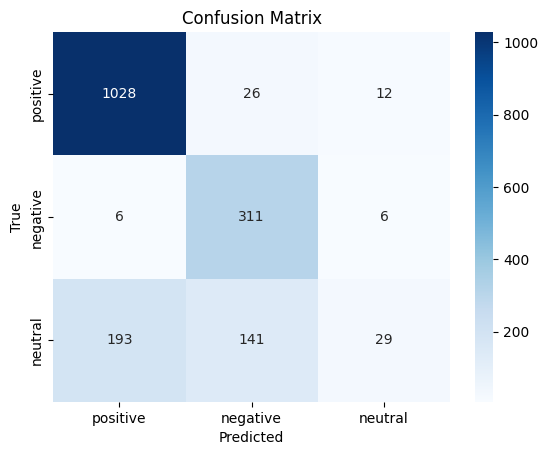

In [12]:
# confusion matrix of result

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

cm = confusion_matrix(result['label'], result['pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [107]:
def conversion(test):
    test = test[1:]
    for i in range(len(test)):
        test[i] = test[i].replace("\n", "").strip()

    # convert text list to string
    test = '\n'.join(test)
    return test

incorrect = result[result['label'] != result['pred']]
incorrect['reasoning'] = incorrect['reasoning'].apply(lambda x: conversion(x))
incorrect.to_csv(os.path.join(output_path, f"incorrect_{data_fname.split('.')[0]}.csv"), index=False)

/var/folders/gl/bjvjzmt13dzgvftlrd57gnv40000gn/T/ipykernel_29257/1520649097.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect['reasoning'] = incorrect['reasoning'].apply(lambda x: conversion(x))


In [14]:
import pandas as pd

# load the result
result = pd.read_csv("output/output_llama3.1_cot_Implicit_Labeled_data_for_test.csv")
incorrect = result[result['label'] != result['pred']]
incorrect.to_csv("output/incorrect_llama3.1_cot_Implicit_Labeled_data_for_test.csv", index=False)

In [10]:
print(incorrect.iloc[0]['reasoning'])

[{'role': 'system', 'content': 'You are an expert of sentiment and opinion analysis.'}, {'role': 'user', 'content': 'Given the sentence "no installation disk (dvd) is included.",  which specific aspect of installation disk (DVD) is possibly mentioned? \n    Answer briefly without explanation.\n    '}, {'role': 'assistant', 'content': 'Availability/Inclusion'}, {'role': 'user', 'content': ' Given the sentence "no installation disk (dvd) is included.",  and the mentioned aspect is about Availability/Inclusion. \n    Based on the common sense, what is the implicit opinion towards the mentioned aspect of installation disk (DVD), and why? \n    Answer briefly without explanation.\n    '}, {'role': 'assistant', 'content': 'Negative.\nBecause "no" implies exclusion or lack.'}, {'role': 'user', 'content': ' Given the sentence "no installation disk (dvd) is included.",  and the mentioned aspect is about Availability/Inclusion. The opinion towards the mentioned aspect of installation disk (DVD) 

In [63]:
import pandas as pd

all_result = pd.DataFrame()

for f in os.listdir("output"):
    if f.endswith(".csv"):
        result = pd.read_csv(os.path.join("output", f))
        if f.split('_')[1] == "llama3.1":
            result['model'] = "llama3.1:8b"
        elif f.split('_')[1] == "llama3.2":
            result['model'] = "llama3.2:3b"
        else:
            result['model'] = f.split('_')[1]
        result['method'] = f.split('_')[2]
        all_result = pd.concat([all_result, result])

all_result

,sentence,target,label,implicit,source,pred,reasoning,model,method
0,"boot time is super fast, around anywhere from ...",Boot time,0,0,laptops,0,"[{'role': 'system', 'content': 'You are an exp...",llama3.2:1b,direct
1,tech support would not fix the problem unless ...,tech support,1,0,laptops,0,"[{'role': 'system', 'content': 'You are an exp...",llama3.2:1b,direct
2,set up was easy.,Set up,0,0,laptops,0,"[{'role': 'system', 'content': 'You are an exp...",llama3.2:1b,direct
3,did not enjoy the new windows 8 and touchscree...,Windows 8,1,0,laptops,0,"[{'role': 'system', 'content': 'You are an exp...",llama3.2:1b,direct
4,did not enjoy the new windows 8 and touchscree...,touchscreen functions,1,0,laptops,1,"[{'role': 'system', 'content': 'You are an exp...",llama3.2:1b,direct
...,...,...,...,...,...,...,...,...,...
1747,"creamy appetizers--taramasalata, eggplant sala...",Creamy appetizers,0,0,restaurants,0,"[{'role': 'system', 'content': 'You are an exp...",llama3.2:3b,cot
1748,"creamy appetizers--taramasalata, eggplant sala...",warm pitas,2,0,restaurants,0,"[{'role': 'system', 'content': 'You are an exp...",llama3.2:3b,cot
1749,"creamy appetizers--taramasalata, eggplant sala...",taramasalata,0,0,restaurants,0,"[{'role': 'system', 'content': 'You are an exp...",llama3.2:3b,cot
1750,"creamy appetizers--taramasalata, eggplant sala...",eggplant salad,0,0,restaurants,0,"[{'role': 'system', 'content': 'You are an exp...",llama3.2:3b,cot


In [64]:
# calculate the accuracy and f1 score for each model and method and implicit/explicit

accs = []
f1s = []
explicit_accs = []
explicit_f1s = []
implicit_accs = []
implicit_f1s = []
df = pd.DataFrame()

for model in all_result['model'].unique():
    for method in all_result['method'].unique():
        result = all_result[(all_result['model'] == model) & (all_result['method'] == method)]
        acc, f1 = evaluate_result(result)
        accs.append(acc)
        f1s.append(f1)
        explicit_acc, explicit_f1 = evaluate_result(result[result['implicit'] == 0])
        implicit_acc, implicit_f1 = evaluate_result(result[result['implicit'] == 1])
        explicit_accs.append(explicit_acc)
        explicit_f1s.append(explicit_f1)
        implicit_accs.append(implicit_acc)
        implicit_f1s.append(implicit_f1)
        
        print(f"Model: {model}, Method: {method}, Accuracy: {acc:.3f}, F1: {f1:.3f}")
        print(f"Model: {model}, Method: {method}, Accuracy (explicit only): {explicit_acc:.3f}, F1 (explicit only): {explicit_f1:.3f}")
        print(f"Model: {model}, Method: {method}, Accuracy (implicit only): {implicit_acc:.3f}, F1 (implicit only): {implicit_f1:.3f}")
        
        df = pd.concat([df, pd.DataFrame({'model': [model], 'method': [method], 'acc': [acc], 'f1': [f1], 'type': ['all']})])
        df = pd.concat([df, pd.DataFrame({'model': [model], 'method': [method], 'acc': [explicit_acc], 'f1': [explicit_f1], 'type': ['explicit']})])
        df = pd.concat([df, pd.DataFrame({'model': [model], 'method': [method], 'acc': [implicit_acc], 'f1': [implicit_f1], 'type': ['implicit']})])

Model: llama3.2:1b, Method: direct, Accuracy: 0.675, F1: 0.438
Model: llama3.2:1b, Method: direct, Accuracy (explicit only): 0.796, F1 (explicit only): 0.479
Model: llama3.2:1b, Method: direct, Accuracy (implicit only): 0.314, F1 (implicit only): 0.285
Model: llama3.2:1b, Method: cot, Accuracy: 0.618, F1: 0.454
Model: llama3.2:1b, Method: cot, Accuracy (explicit only): 0.712, F1 (explicit only): 0.483
Model: llama3.2:1b, Method: cot, Accuracy (implicit only): 0.337, F1 (implicit only): 0.322
Model: llama3.2:1b, Method: cot-fewshot, Accuracy: 0.438, F1: 0.400
Model: llama3.2:1b, Method: cot-fewshot, Accuracy (explicit only): 0.474, F1 (explicit only): 0.394
Model: llama3.2:1b, Method: cot-fewshot, Accuracy (implicit only): 0.328, F1 (implicit only): 0.326
Model: llama3.1:8b, Method: direct, Accuracy: 0.701, F1: 0.484
Model: llama3.1:8b, Method: direct, Accuracy (explicit only): 0.819, F1 (explicit only): 0.516
Model: llama3.1:8b, Method: direct, Accuracy (implicit only): 0.349, F1 (impl

In [65]:
df.sort_values("model")

,model,method,acc,f1,type
0,llama3.1:8b,cot,0.802334,0.579482,explicit
0,llama3.1:8b,cot-fewshot,0.514806,0.520945,implicit
0,llama3.1:8b,cot-fewshot,0.886519,0.685656,explicit
0,llama3.1:8b,cot-fewshot,0.793379,0.668031,all
0,llama3.1:8b,cot,0.293078,0.305425,implicit
0,llama3.1:8b,cot,0.640449,0.507819,all
0,llama3.1:8b,direct,0.348519,0.337423,implicit
0,llama3.1:8b,direct,0.818736,0.515935,explicit
0,llama3.1:8b,direct,0.700913,0.484322,all
0,llama3.2:1b,direct,0.675228,0.438429,all


In [78]:
df.to_csv("output/acc_f1.csv", index=False)

In [79]:
df = pd.read_csv("output/acc_f1.csv")

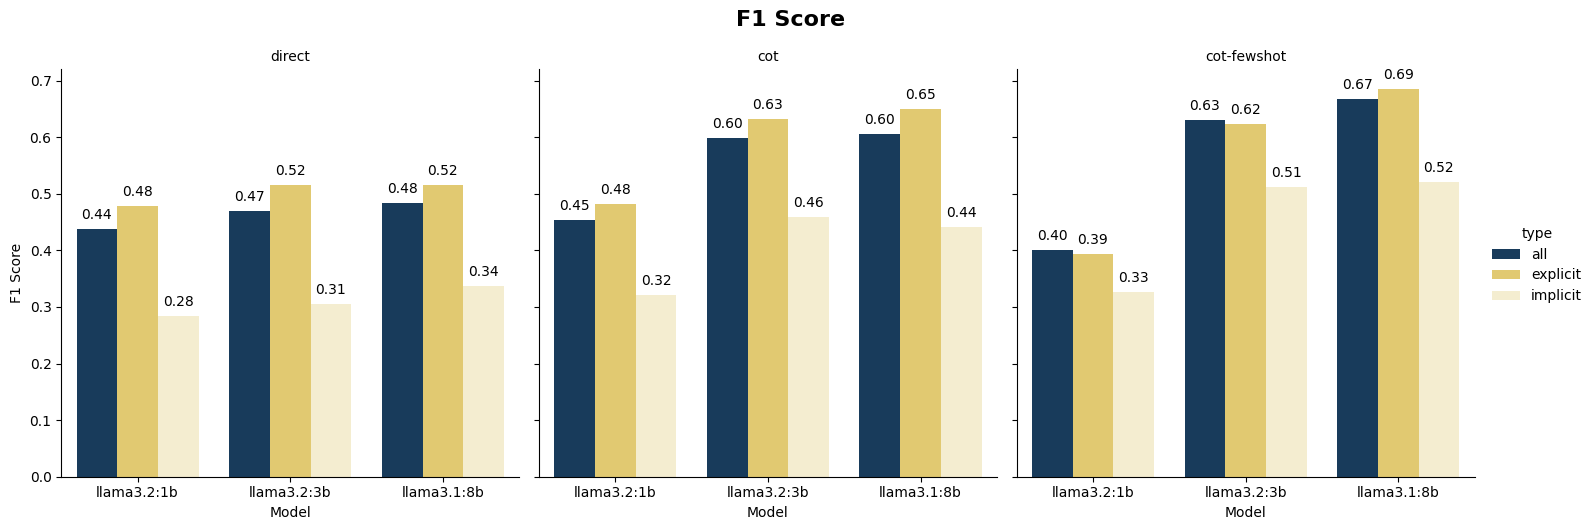

In [80]:
# plot the accuracy and f1 score for each model and method and implicit/explicit

# Ensure the x-axis is sorted by the specified order
df['model'] = pd.Categorical(df['model'], categories=['llama3.2:1b', 'llama3.2:3b', 'llama3.1:8b'], ordered=True)

g = sns.catplot(data=df, x='model', y='f1', hue='type', col='method', kind='bar', palette=["#0d3b66", "#f4d35e", "#faf0ca"])
g.set_axis_labels("Model", "F1 Score")
g.set_titles("{col_name}")
plt.suptitle('F1 Score', y=1.05, fontsize=16, fontweight='bold')

# Add number labels on each bar
for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() == 0:
            continue
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


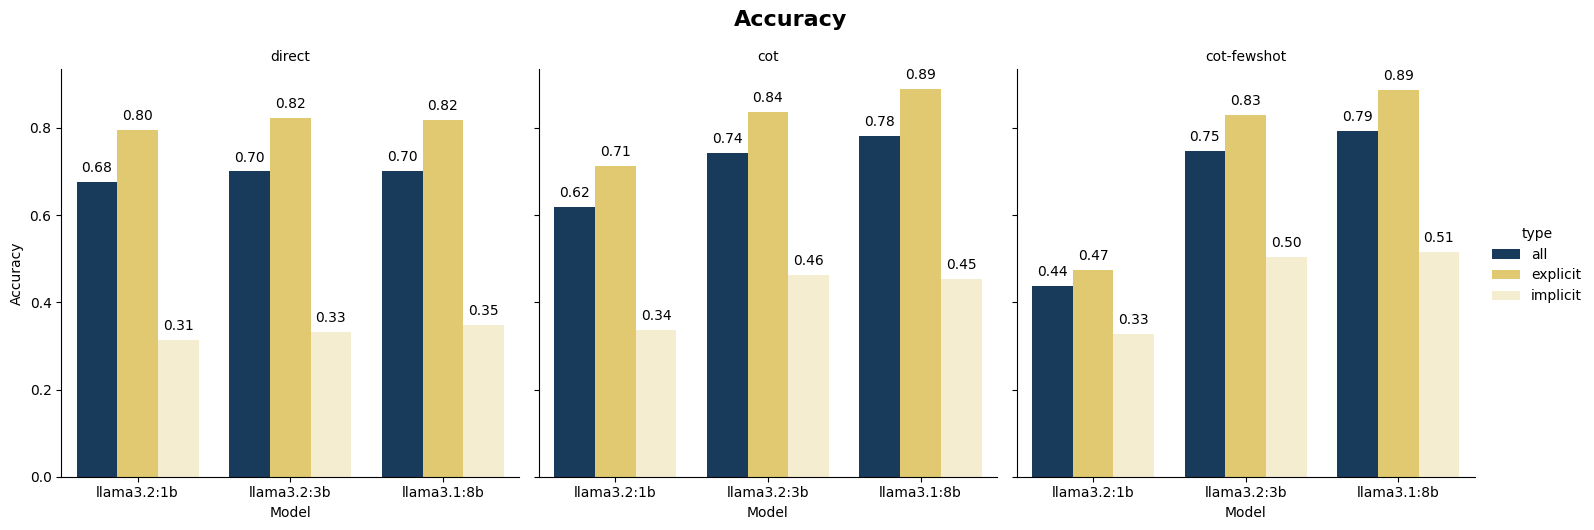

In [81]:
    
import matplotlib.pyplot as plt
import seaborn as sns

# plot the accuracy and f1 score for each model and method and implicit/explicit

g = sns.catplot(data=df, x='model', y='acc', hue='type', col='method', kind='bar', palette=["#0d3b66", "#f4d35e", "#faf0ca"])
g.set_axis_labels("Model", "Accuracy")
g.set_titles("{col_name}")
plt.suptitle('Accuracy', y=1.05, fontsize=16, fontweight='bold')

# Add number labels on each bar
for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() == 0:
            continue
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
plt.show()

In [68]:
all_result['method'].unique()

array(['direct', 'cot', 'cot-fewshot'], dtype=object)

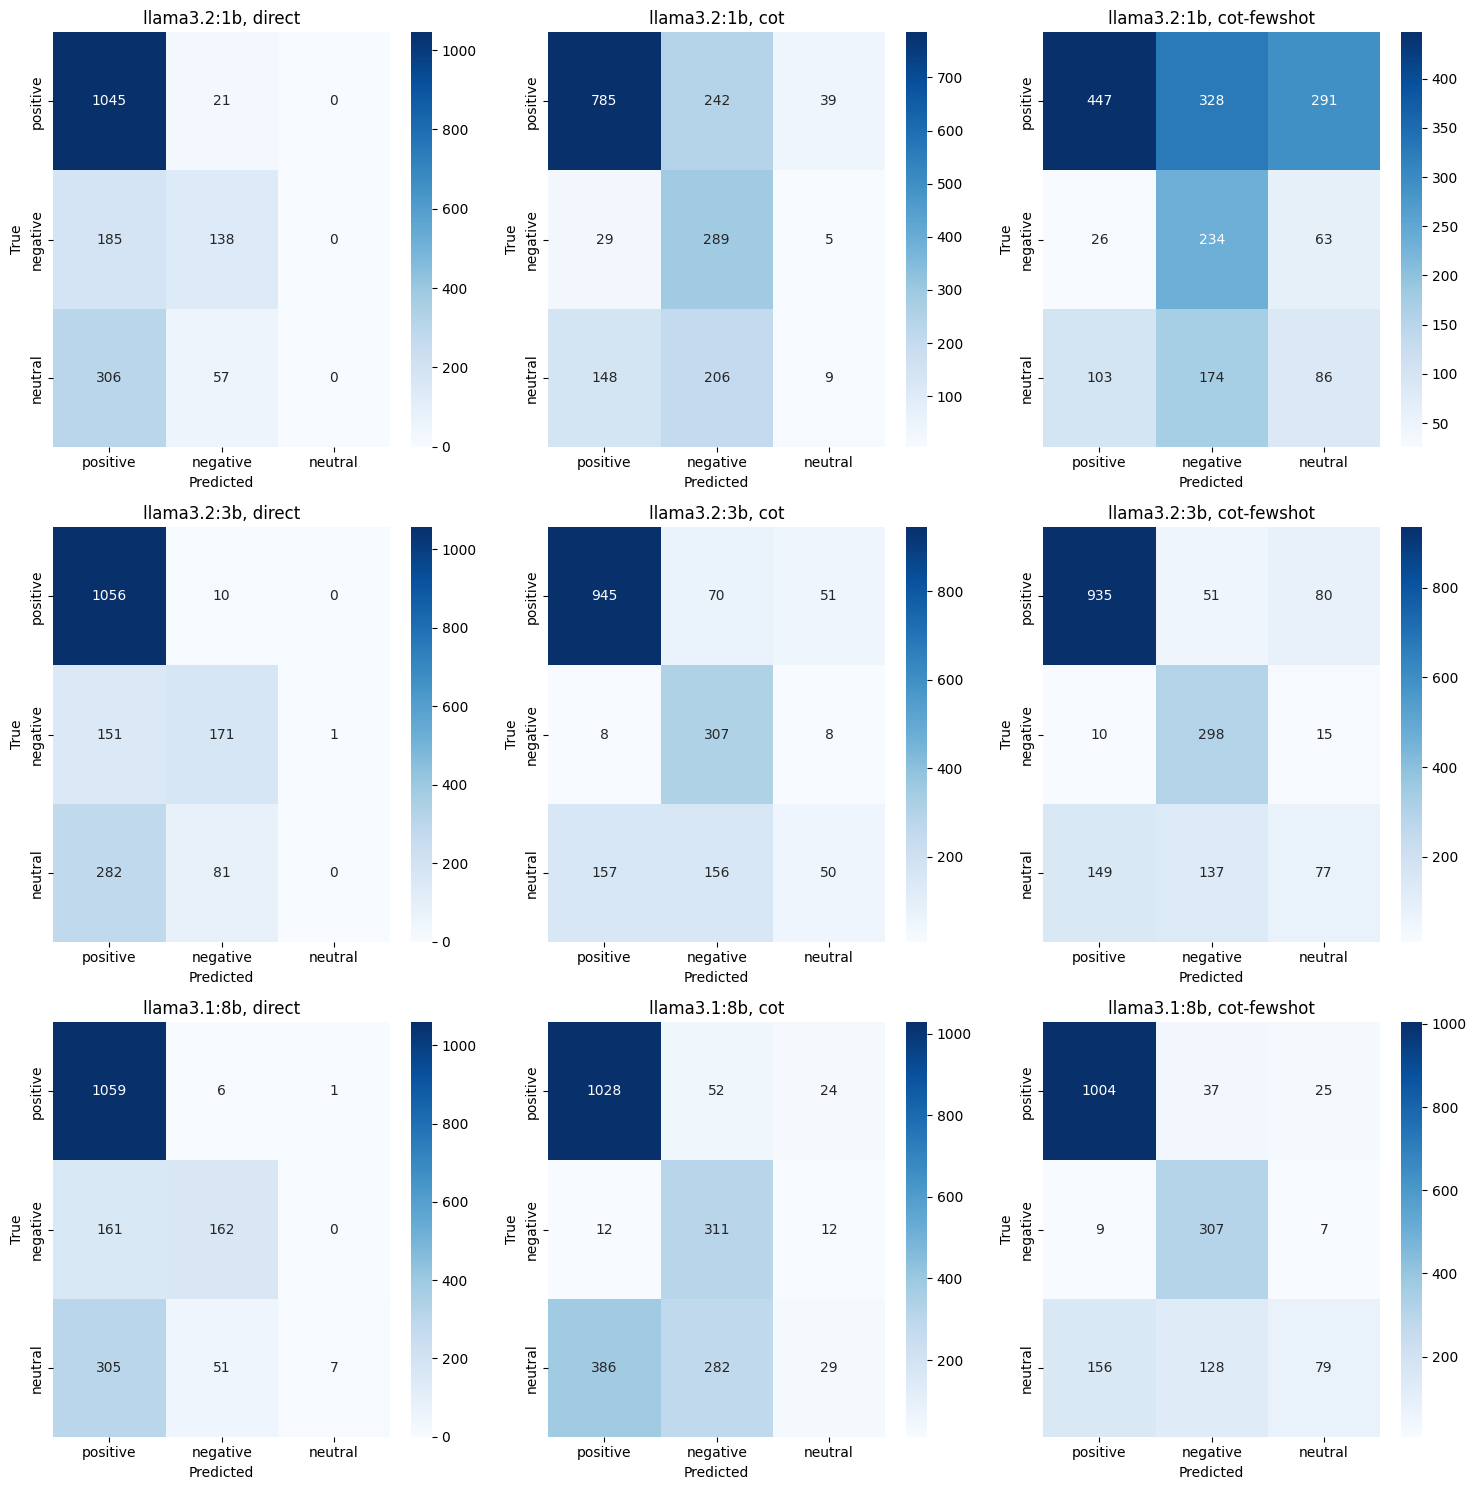

In [70]:
# confusion matrix of result

label_list = ['positive', 'negative', 'neutral']

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

fig, axes = plt.subplots(len(all_result['model'].unique()), len(all_result['method'].unique()), figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, model in enumerate(['llama3.2:1b', 'llama3.2:3b', 'llama3.1:8b']):
    for j, method in enumerate(all_result['method'].unique()):
        result = all_result[(all_result['model'] == model) & (all_result['method'] == method)]
        cm = confusion_matrix(result['label'], result['pred'])
        ax = axes[i, j]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'{model}, {method}')

plt.tight_layout()
plt.show()
        